gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!pip install cellpose

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

In [1]:
# Import modules
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models
from cellpose.io import imread
from cellpose import plot
from skimage.util import img_as_ubyte
import pandas as pd

In [152]:
import scipy
from scipy import ndimage as ndi
import cv2

# https://stackoverflow.com/questions/19970764/making-feature-vector-from-gabor-filters-for-classification
# https://stackoverflow.com/questions/20608458/gabor-feature-extraction

In [3]:
#------------------------------------------------------
# Number of images we want to read. Only in test phase. If we want to read all images we will use len(Cherry_file) in for loop below
nb_images = 1

# Get path to folders containing images
Image_Directory = os.getcwd() + "\\20151218_E14_BM_mTF8additionals_4"
#Image_Directory = r"C:\Users\alexi\EPFL\MA3\Machine_learning\20151218_E14_BM_mTF8additionals_4"  #Easier for me (Alexis) than finding of to get my path file nicely
#Image_Directory = "/content/gdrive/MyDrive/ML_2_transcripted_cherry/TF1"
# other folders: 
# \\20151218_E14_BM_mTF8additionals_4

print(Image_Directory)

# Calculate number of document-> array containing 

# Create Lists containing datapath to all images of Cherry/ Ypet files
image_format = "tif"
cherry_condition = "TexasRed"
ypet_condition = "YFP"
Cherry_file = []
Ypet_file = []
test = []

# Walk through directory (call all files) and assign them to proper list
for root, dirs, files in os.walk(Image_Directory, topdown=False): # root = given in Input, dirs = folders, files= files
    for f in files:
        if f.endswith(image_format) and cherry_condition in f: 
            test.append(f)
            Cherry_file.append(os.path.join(root, f))
        elif f.endswith(image_format) and ypet_condition in f: 
            Ypet_file.append(os.path.join(root, f))

#assert len(Cherry_file) != len(Ypet_file), f"There are {len(Cherry_file)} Cherry files and {len(Ypet_file)} Ypet files. The number has to be equal, check manually what's missing"


# Initialize lists containing cherry, ypet images. Length = nb_images or len(Cherry_file) if we want to read all images
cherry_imgs = np.ndarray(nb_images,dtype = np.ndarray)
ypet_imgs = np.ndarray(nb_images,dtype = np.ndarray)


# Read image (We donnot add it in for loop above to enable reading subset of image)
for i in range(nb_images): #len(Cherry_file):
    cherry_imgs[i] = imread(Cherry_file[i])
    ypet_imgs[i] = imread(Ypet_file[i])
    
cherry_imgs = cherry_imgs.tolist()
ypet_imgs = ypet_imgs.tolist()

C:\Users\Sophia\Documents\EPFL\3rd_semester\Machine learning\project\P2\20151218_E14_BM_mTF8additionals_4


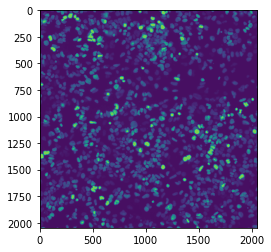

In [4]:
plt.imshow(imread(Ypet_file[0]))

In [5]:
# Definine parameters for cellpose module using nuclei modus
# https://cellpose.readthedocs.io/en/latest/settings.html
channels = [0,0] # Corresponds to greyscale image
diameter = None # Model was trained on diameters of 17 pixels. None-> automated estimation of the diameter. Can be changed by hand later
flow_threshold = 0.4 # maximum allowed error of the flows for each mask, default = 0.4
gpu = False
model_type='nuclei'

# Set model
model = models.Cellpose(gpu, model_type)

# Nuclei segmentation of all images within cherry_imgs list
masks, flows, styles, diams = model.eval(cherry_imgs, diameter=diameter, channels=channels, flow_threshold=flow_threshold, do_3D=False)


In [5]:
'''
from cellpose import io
import os
#os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1")
files_names = ["/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_"+str(i+1) for i in range(nb_images)]
io.masks_flows_to_seg(cherry_imgs, masks, flows, diams, files_names, channels)'''

'\nfrom cellpose import io\nimport os\n#os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1")\nfiles_names = ["/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_"+str(i+1) for i in range(nb_images)]\nio.masks_flows_to_seg(cherry_imgs, masks, flows, diams, files_names, channels)'

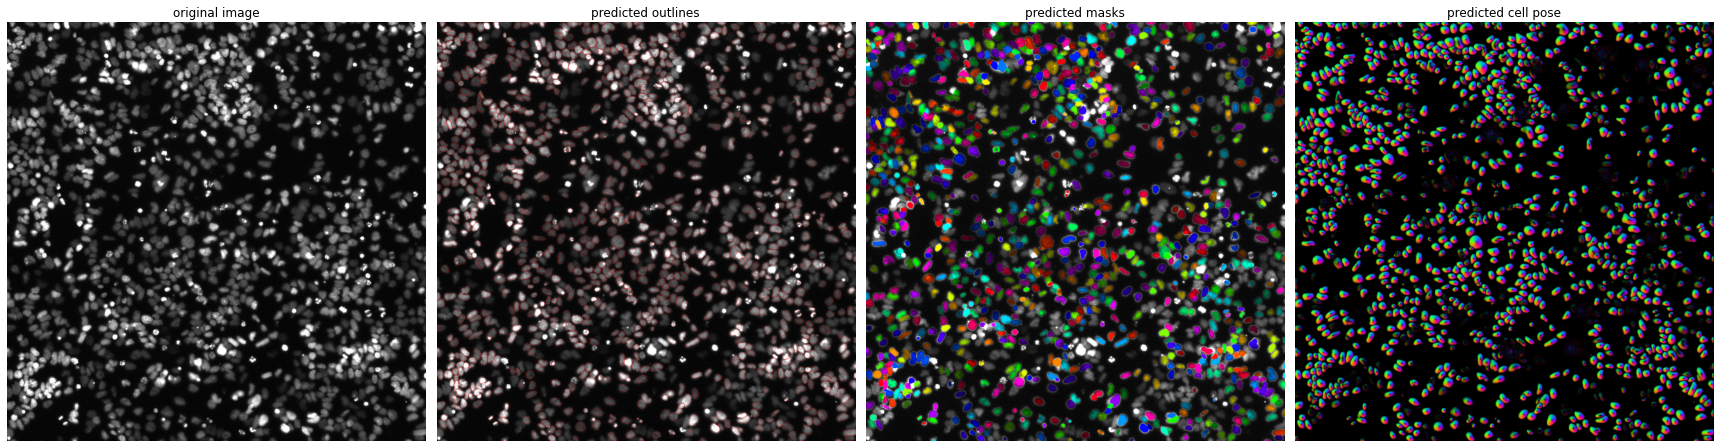

In [6]:
# Display results
image_i = 0 # Number of image we want to display. Max value= nb_images or len(Cherry_file)
fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, cherry_imgs[image_i], masks[image_i], flows[image_i][0], channels)
plt.tight_layout()
plt.show()

***
Sophia explore

In [115]:
a = np.array([[0,0,0,0,2,2,8,2],[7,1,1,1,5,2,1,0],[0,0,0,1,2,3,4,9]])
a

array([[0, 0, 0, 0, 2, 2, 8, 2],
       [7, 1, 1, 1, 5, 2, 1, 0],
       [0, 0, 0, 1, 2, 3, 4, 9]])

In [118]:
boolean = np.where(a==3, 1,False) # Boolean matrix where patch = true
boolean
patch_boolean = a*boolean
patch_boolean

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0]])

Manually find right gabor filter settings: <br>
Nucleus is around 40 pixels -> kernel should be 1/2, 1/4 size<br>


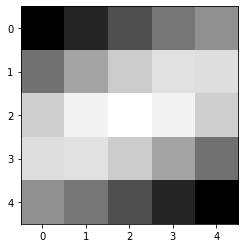

In [136]:
sigmas = [1,3]
tilts = [0,0.25,0.5,0.75] # perpendicular, diagonal, horizontal, other diagonal 
Wavelengths = [0,0.25,0.5,0.75] 
gamma =  0.5 # Spatial aspect ratio
psi = 0 # Phase offset.
for tilt in tilts:
    for sigma in sigmas:
        for lambd in Wavelengths:
            kernel = cv2.getGaborKernel((10,10), sigma, tilt, lambd, gamma, psi, ktype = cv2.CV_32F)
            plt.imshow(kernel, cmap='gray')

In [213]:
a = [1,3]
for i in a:
    print(i)

1
3


<Figure size 432x288 with 0 Axes>

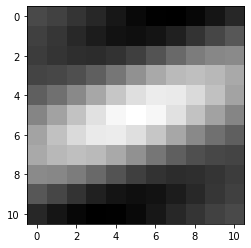

In [159]:
# prepare Gabor filter bank kernels
kernels = []

sigmas = [1,3]
tilts = [0,0.25,0.5,0.75] # perpendicular, diagonal, horizontal, other diagonal 
Wavelengths = [0,0.75] 
gamma =  0.5 # Spatial aspect ratio
psi = 0 # Phase offset.
for tilt in tilts:
    for sigma in sigmas:
        for lambd in Wavelengths:
            kernel = cv2.getGaborKernel((10,10), sigma, tilt, lambd, gamma, psi, ktype = cv2.CV_32F)
            kernels.append(kernel)

image = patch_data
g_response = []
feats = np.zeros((len(kernels), 2), dtype=np.double)
plt.figure()
for k, kernel in enumerate(kernels):
    filtered = ndi.convolve(image, kernel, mode='wrap')
    g_response.append(filtered)
plt.figure()
plt.imshow(kernel, cmap='gray')

In [160]:
len(g_response)

16

***

In [8]:
# prepare Gabor filter bank kernels
kernels = []

sigmas = [1,3]
tilts = [0,0.25,0.5,0.75] # perpendicular, diagonal, horizontal, other diagonal 
Wavelengths = [0,0.25,0.5,0.75] 
gamma =  0.5 # Spatial aspect ratio
psi = 0 # Phase offset.
for tilt in tilts:
    for sigma in sigmas:
        for lambd in Wavelengths:
            kernel = cv2.getGaborKernel((10,10), sigma, tilt, lambd, gamma, psi, ktype = cv2.CV_32F)
            kernels.append(kernel)

            
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

In [ ]:
# Initialize list of features 
columnname = ["" for i in range(1)]
patch_size = [0 for i in range(1)]
mean_intensity = [0 for i in range(1)]
sum_intensity = [0 for i in range(1)]
median_intensity = [0 for i in range(1)]
variance_intensity = [0 for i in range(1)]
imgs = [-1 for i in range(1)]

In [10]:
from skimage.morphology import square, dilation

In [120]:
# Extract feature of each nucleus within images nb_images
for j in range(nb_images):
    
    # Initialize features
    mask =  masks[j]   
    range_s =  range(1,len(np.unique(mask)))  #IMAGE SPECIFIC: cases where cell are big enough (sell last cell of the notebook)
    
    imgs = [j for i in range_s]
    ypet = ypet_imgs[j]
    columnname = ["" for i in range_s]
    patch_size = [0 for i in range_s]
    mean_intensity = [0 for i in range_s]
    sum_intensity = [0 for i in range_s]
    median_intensity = [0 for i in range_s]

    std_intensity = [0 for i in range_s]
    var_intensity = [0 for i in range_s]
    skew_intesity = [0 for i in range_s]
    kurt_intesity = [0 for i in range_s]
    iqr_intesity = [0 for i in range_s]
    entropy_intesity = [0 for i in range_s]
    
    # Iterate through all nucleus: Take submatrix, Calculate patch size and corresponding ypet signal (mean) and store it into ypet_intensity
    iter_i = 0 # Ensures that no 0 are saved where patch is too small/big
    
    for i in range(1,23):#range_s : # Iterate through all nucleus: 
        cur = ypet[mask==i]
        patch_size_ = np.count_nonzero(~np.isnan(cur))
        
        # Extract subimage ----------------------------------------------------------------
        # Extract subimage of nucleus (Not just its values, which is done above)
        boolean = np.where(mask==i, 1,False) # Boolean matrix where patch = 1, else 0
        patch_values = ypet*boolean
        # Extract submatrix with a buffer of 5 pixels to calculate the blurrness
        variance_boolean = dilation(boolean, square(11))
        variance_values = ypet * variance_boolean
        
        # Drop pixels without nucleus information ----------------------------------------------------------------
        # Initialize conditions on when a column/ row should be dropped
        drop_nucleus = False
        drop_column = []
        drop_column_variance = []
        drop_row = []
        drop_row_variance = []
        var_threshold = 120 #<---------------------------------------------------------------- to define'''
        
        # Iterate through all columns to find nucleus that is on the border and the columns that only contain mask
        for column in range(boolean.shape[1]):
            
            # drop nucleus if it's on the border 
            if (((column == 0) | (column == boolean.shape[1]-1)) & (np.any(boolean[:,column])== True)):
                drop_nucleus = True
                break 
                
            # drop if column has no information about nucleus: first check for broader variance_submatrix (Matrix with a buffer around submatrix to calculate variance). Then smaller submatrix 
            if np.any(variance_boolean[:,column])== False:
                drop_column_variance.append(column) 
                drop_column.append(column) 
            elif np.any(boolean[:,column])== False: 
                drop_column.append(column) 
        
        # Iterate through all columns to find nucleus that is on the border and the columns that only contain mask
        for row in range(boolean.shape[0]):
            
            # drop nucleus if it's on the border 
            if (((row == 0) | (row == boolean.shape[0]-1)) & (np.any(boolean[row,:])== True)):
                drop_nucleus = True
                break
                
            # drop if row has no information about nucleus:  first check for broader variance_submatrix  
            if np.any(variance_boolean[row,:])== False:
                drop_row.append(row)
                drop_row_variance.append(row)
            elif np.any(boolean[row,:])== False: 
                drop_row.append(row)
        
        # Drop pixels without nucleus information
        patch_data = np.delete(patch_values,drop_column,1)  
        patch_data = np.delete(patch_data,drop_row,0) 
        variance_data = np.delete(ypet,drop_column_variance,1)  
        variance_data = np.delete(variance_data,drop_row_variance,0) 
        
        # Calculate blurness ----------------------------------------------------------------
        var_lapl = cv2.Laplacian(variance_data, cv2.CV_64F).var()
        if var_lapl < var_threshold: # nucleus is blurry
            drop_nucleus = True
            break
        
        # Feature calculation ----------------------------------------------------------------
        
        if ((patch_size_ > 10) & (patch_size_ < 50000) & (drop_nucleus== False)): 

            # extract intensity feature
            columnname[iter_i] = "patch_" + str(iter_i)    #We should not forgot that there is a -1 here. (when it is here)               
            patch_size[iter_i] = patch_size_
            sum_intensity[iter_i] = np.sum(np.sum(cur))
            mean_intensity[iter_i] = np.nanmean(cur)
            median_intensity[iter_i] = np.nanmedian(cur)
            
            std_intensity[iter_i] = np.nanstd(cur)
            var_intensity[iter_i] = np.nanvar(cur)
            skew_intesity[iter_i] = scipy.stats.skew(cur)
            kurt_intesity[iter_i] = scipy.stats.kurtosis(cur)
            iqr_intesity[iter_i] = scipy.stats.iqr(cur)
            entropy_intesity[iter_i] = scipy.stats.entropy(cur)
            
            
            #gabor = compute_feats(patch_data, kernels)
            
            iter_i +=1
    
    # Drop empty rows: some patches values were not calculated because their size is too small/big 
    if iter_i != range_s: # Some patches were not considered -> we have to drop those rows
        mean_intensity = mean_intensity[:iter_i]
        columnname = columnname[:iter_i]
        patch_size = patch_size[:iter_i]
        sum_intensity = sum_intensity[:iter_i]
        median_intensity = median_intensity[:iter_i]
        imgs = imgs[:iter_i]
        
        std_intensity = std_intensity[:iter_i] 
        var_intensity = var_intensity[:iter_i] 
        skew_intesity = skew_intesity[:iter_i] 
        kurt_intesity = kurt_intesity[:iter_i] 
        iqr_intesity = iqr_intesity[:iter_i]
        entropy_intesity = entropy_intesity[:iter_i] 
        
        
    ypet_intensity = pd.DataFrame(index=columnname)
    ypet_intensity['img'] = imgs
    ypet_intensity['patch_size'] = patch_size
    ypet_intensity['mean_intensity'] = mean_intensity
    ypet_intensity['sum_intensity'] = sum_intensity
    ypet_intensity['median_intensity'] = median_intensity
    
    ypet_intensity['standard_deviation'] = std_intensity 
    ypet_intensity['variance'] = var_intensity
    ypet_intensity['skewness'] = skew_intesity
    ypet_intensity['kurtosis'] = kurt_intesity
    ypet_intensity['interquartile_range ']= iqr_intesity
    ypet_intensity['entropy'] = entropy_intesity
   
    #ypet_intensity_glob = pd.concat([ypet_intensity_glob,ypet_intensity])
    print("step "+str(j)+" over "+str(nb_images)+ " is done!")
    

step 0 over 1 is done!


In [121]:
drop_nucleus

False

In [122]:
ypet_intensity

,img,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,variance,skewness,kurtosis,interquartile_range,entropy
patch_0,0,791,12062.793932,9541670,12567.0,3952.360713,1.562116e+07,-0.566869,-0.116372,4865.0,6.612018
patch_1,0,2177,11771.050069,25625576,12003.0,3412.326367,1.164397e+07,-0.562391,0.340297,3889.0,7.638497


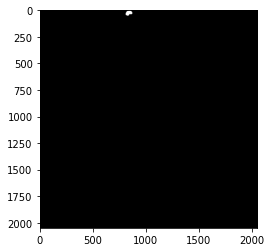

In [123]:
plt.imshow(boolean, cmap='gray')

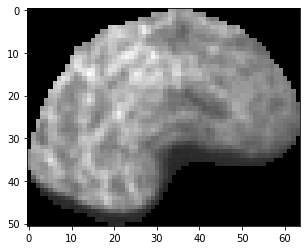

In [124]:
plt.imshow(patch_data, cmap='gray')

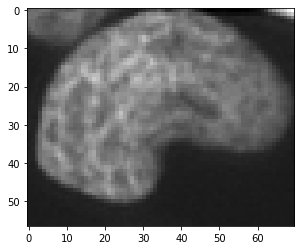

In [125]:
plt.imshow(variance_data, cmap='gray')

In [46]:
import cv2

In [94]:
var_lapl = cv2.Laplacian(variance_data[5:,:], cv2.CV_64F).var()
var_lapl

573691.7320720215

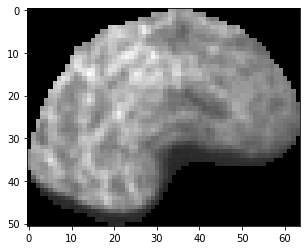

In [119]:
plt.imshow(patch_data, cmap='gray')

In [ ]:
path = '/content/drive/MyDrive/Project_2_ml/20151218_E14_BM_mTF8additionals_4/Features/features_cells_TF8_A1.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
    ypet_intensity_glob.to_csv(f)

"""  Was just to create the ~800 folders easier :)
import os
alphabet = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
for k in range(8):
  for j in range(8):
    for i in range(12):
      os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF"+str(k+1)+"/"+alphabet[j]+"_"+str(i+1))
"""

''' to remove the "copie" part of it once I did copy
import os
os.rename("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/Copie de img_1_seg.npy","/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_1_seg.npy")
'''
